In [58]:
from importlib import reload
from datetime import datetime
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import utils
reload(utils)

<module 'utils' from '/Users/andreanonali/Documents/DataScienceForBusiness/utils.py'>

In [59]:
ceased_labours = pd.read_csv('Rapporti_di_lavoro_cessati.csv')
ceased_labours.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,02/04/2019,M,20,Lavori di meccanica generale,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
1,08/06/2018,F,28,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
2,02/02/2016,F,20,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/01/2015,M,59,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
4,09/08/2017,M,61,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA


In [60]:
ceased_labours.dtypes

DATA                         object
GENERE                       object
ETA                           int64
SETTOREECONOMICODETTAGLIO    object
TITOLOSTUDIO                 object
CONTRATTO                    object
MODALITALAVORO               object
PROVINCIAIMPRESA             object
ITALIANO                     object
dtype: object

### Rename column 'ITALIANO' to 'NAZIONALITA'

In [61]:
ceased_labours.rename({'ITALIANO': 'NAZIONALITA'}, axis=1, inplace=True)

In [62]:
ceased_labours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741394 entries, 0 to 3741393
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DATA                       object
 1   GENERE                     object
 2   ETA                        int64 
 3   SETTOREECONOMICODETTAGLIO  object
 4   TITOLOSTUDIO               object
 5   CONTRATTO                  object
 6   MODALITALAVORO             object
 7   PROVINCIAIMPRESA           object
 8   NAZIONALITA                object
dtypes: int64(1), object(8)
memory usage: 256.9+ MB


# Data cleaning

## Null inspection

In [63]:
utils.missing_values_table(ceased_labours)

Your selected dataframe has 9 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
SETTOREECONOMICODETTAGLIO,1019,0.0
TITOLOSTUDIO,440,0.0


In [64]:
utils.get_percent_missing(ceased_labours, columns=['SETTOREECONOMICODETTAGLIO', 'TITOLOSTUDIO'])

SETTOREECONOMICODETTAGLIO    0.027236
TITOLOSTUDIO                 0.011760
dtype: float64

<AxesSubplot:>

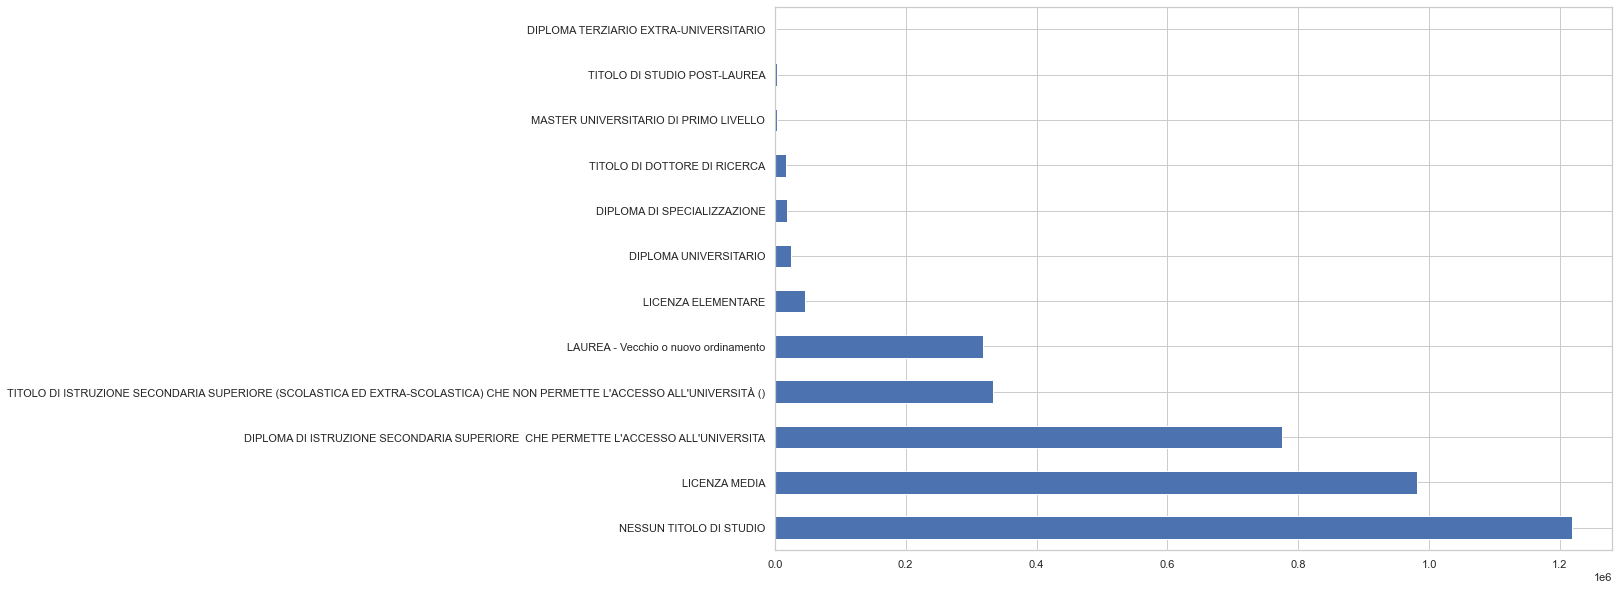

In [65]:
ceased_labours.TITOLOSTUDIO.value_counts().plot(kind='barh')

For the column TITOLOSTUDIO we can see the null values are really a minmal part of the dataset, so we can delete them quite safely wihthout risking to lose information, or risking to add a bias by filling them.
Maybe we can add an 'unkwon' field but the impact is still low

The same goes for the column SETTOREECONOMICODETTAGLIO which has also a huge amount of categorical unique values

In [66]:
ceased_labours.dropna(inplace=True)
utils.missing_values_table(ceased_labours)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Duplicated data inspection

In [67]:
ceased_labours.duplicated().sum()

131649

Do we want to drop duplicates ?
In this case, duplicated columns data means that two people with the same features ceased their job activity. By dropping the duplicates we remove this information, which is relevant.
The number of duplicated values is big. So we can also think about sampling the data to have a smaller set of duplicate values, but the issue is the same of dropping them.

# Data Exploration & statistics

## Continuous data
The only column containing continuous data is 'ETA'

In [68]:
ceased_labours.ETA.describe()

count    3.739935e+06
mean     3.811322e+01
std      1.261621e+01
min      0.000000e+00
25%      2.800000e+01
50%      3.700000e+01
75%      4.700000e+01
max      6.210000e+02
Name: ETA, dtype: float64

We have a max value of 621. Clearly that's human, so we can inspect the column, and probably delete this outlier on the go.

In [69]:
max_age_idx = ceased_labours.ETA.idxmax()
ceased_labours.loc[max_age_idx]

DATA                                                   12/11/2600
GENERE                                                          M
ETA                                                           621
SETTOREECONOMICODETTAGLIO    Fabbricazione di imballaggi in legno
TITOLOSTUDIO                              NESSUN TITOLO DI STUDIO
CONTRATTO                              LAVORO A TEMPO DETERMINATO
MODALITALAVORO                                        TEMPO PIENO
PROVINCIAIMPRESA                                          MANTOVA
NAZIONALITA                                                 GHANA
Name: 1269413, dtype: object

It could be a typo, but we can't guess with certainty the age of the person, that could be a left-to-right combination of the 621, like 62, 21, 61.
For this reason we can drop this record.

In [70]:
ceased_labours.drop(max_age_idx, inplace=True)

We can apply the same reasoning for the minimun value, which is zero.
But in this case we can also remove the values v such that v < 16. 16 years old is the minimum legal age to activate a job.

In [71]:
ceased_labours = ceased_labours[ceased_labours['ETA'] > 16]

### Re-describe after adjusted data

In [72]:
ceased_labours.describe()

,ETA
count,3.731058e+06
mean,3.817740e+01
std,1.255593e+01
min,1.700000e+01
25%,2.800000e+01
50%,3.700000e+01
75%,4.700000e+01
max,1.100000e+02


In [73]:
ceased_labours.ETA.mode()

0    26
Name: ETA, dtype: int64

In [74]:
ceased_labours.ETA.median()

37.0

In [75]:
_range = ceased_labours.ETA.max() - ceased_labours.ETA.min()
_range

93

The mode value is 26, which is nearest to the lower bound than the right one, considering the range of 58. According to the mean and the median, we may think that there is a right skewed probability distribution.


### Data distribution for 'ETA': plotting
We can inspect the distribution of the 'ETA' column. By knowing the distribution we can decide what strategy to apply. For example if it is a **normal distribution** we can use the z-score.

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

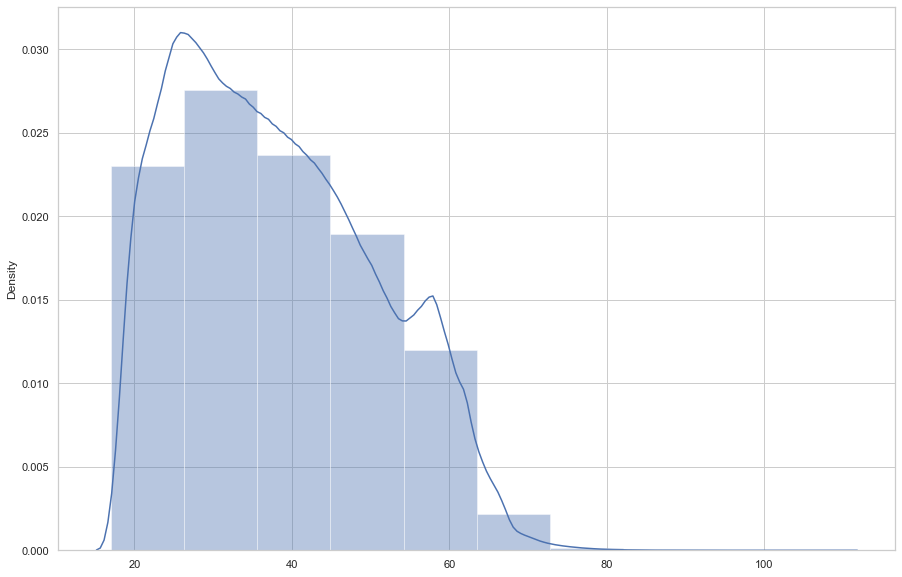

In [76]:
sns.distplot(x=ceased_labours.ETA, bins=10)

The distribution is skewed right. 
Possible outliers may be on the right hand of the distribiution. We can try to plot them with a box plot.

### Outliers

<AxesSubplot:xlabel='ETA'>

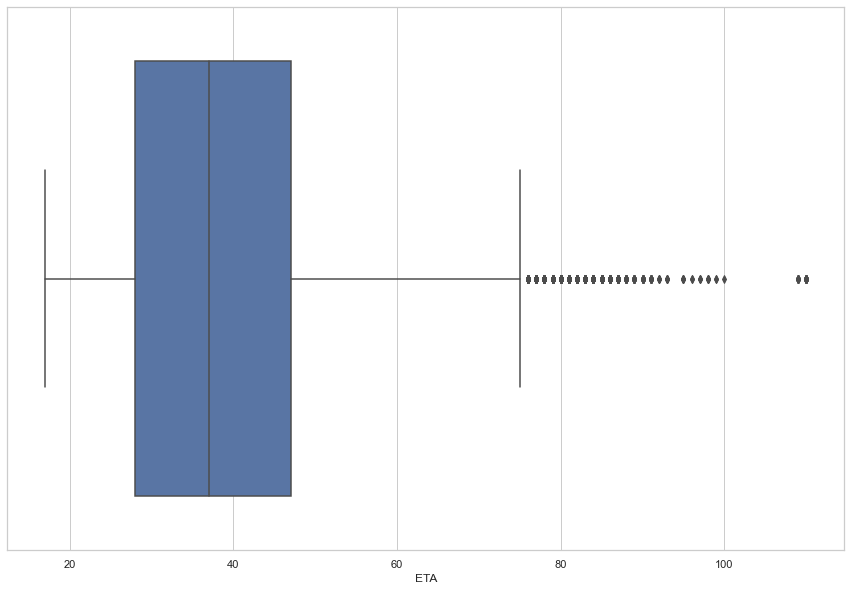

In [77]:
sns.boxplot(x=ceased_labours.ETA)

The box plot confirms the right skewness of the data.
We can try to programmatically remove the values on the right 

<AxesSubplot:xlabel='ETA'>

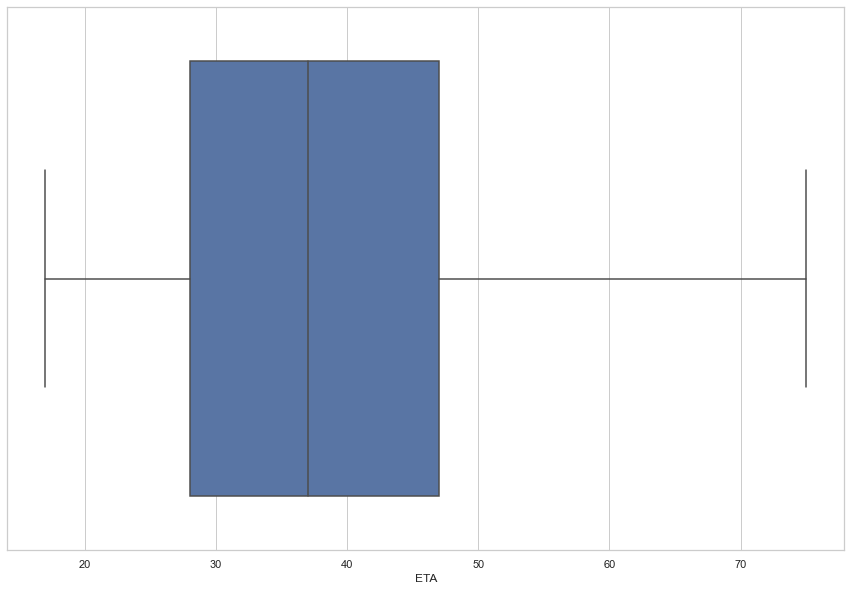

In [78]:
right_whisker = utils.get_right_whisker(ceased_labours, 'ETA')

ceased_labours = ceased_labours[ceased_labours['ETA'] < right_whisker]  

sns.boxplot(x=ceased_labours.ETA)

## Categorical data 

In [79]:
ceased_labours.nunique()

DATA                         2322
GENERE                          2
ETA                            59
SETTOREECONOMICODETTAGLIO    1205
TITOLOSTUDIO                   12
CONTRATTO                      54
MODALITALAVORO                  5
PROVINCIAIMPRESA               12
NAZIONALITA                   197
dtype: int64

I can try to plot the frequency table of some of them

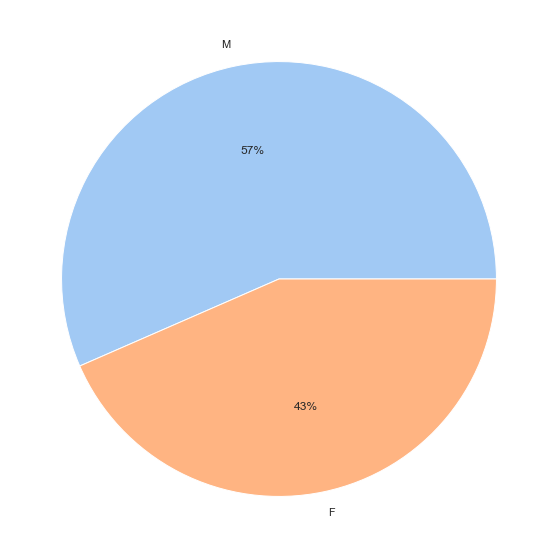

In [80]:
utils.plot_frequency_pie(ceased_labours, 'GENERE')

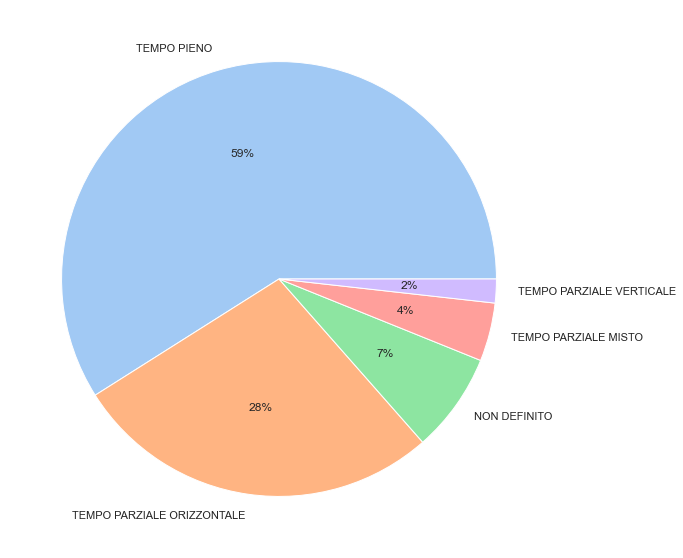

In [81]:
utils.plot_frequency_pie(ceased_labours, 'MODALITALAVORO')

Most of the ceased labours seems to come from full time jobs.

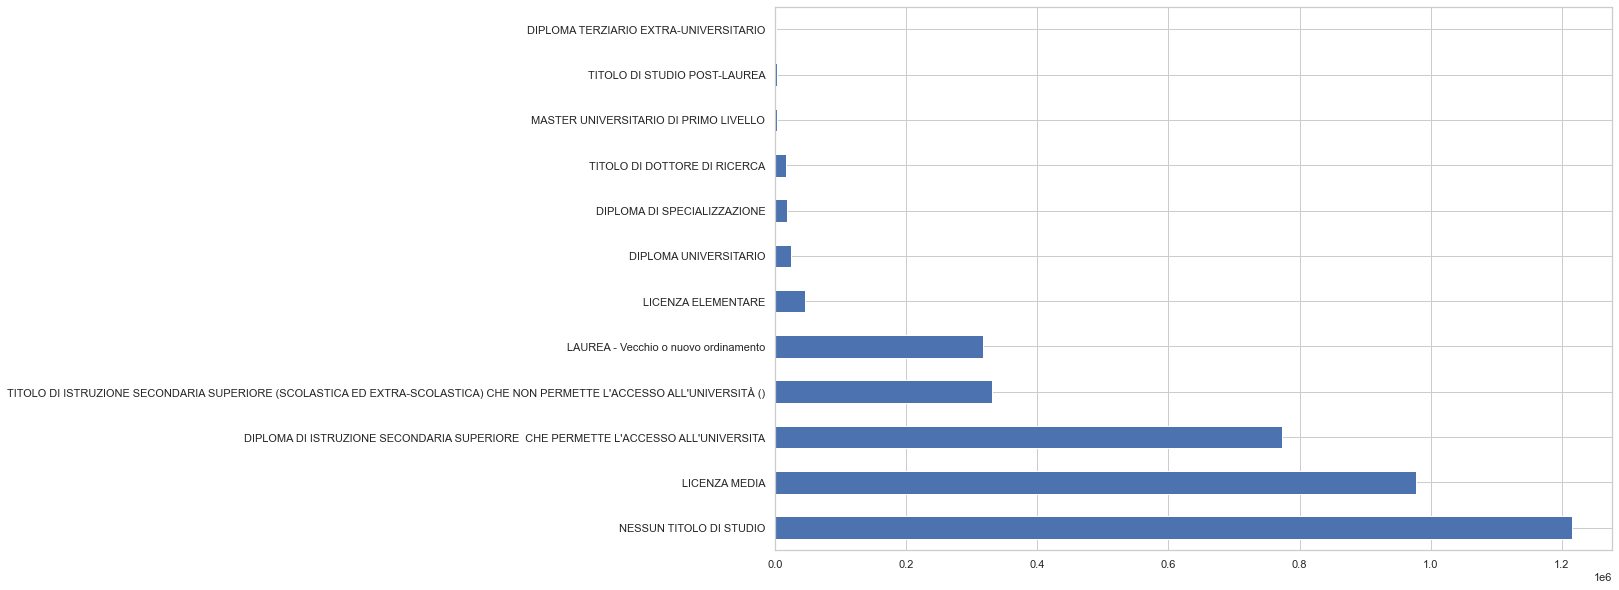

In [82]:
utils.plot_frequency_table(ceased_labours, 'TITOLOSTUDIO')

It seems that educated people have less proability to be fired. However there is also a good amount of people with only elementary school that have low ceased labor probability.

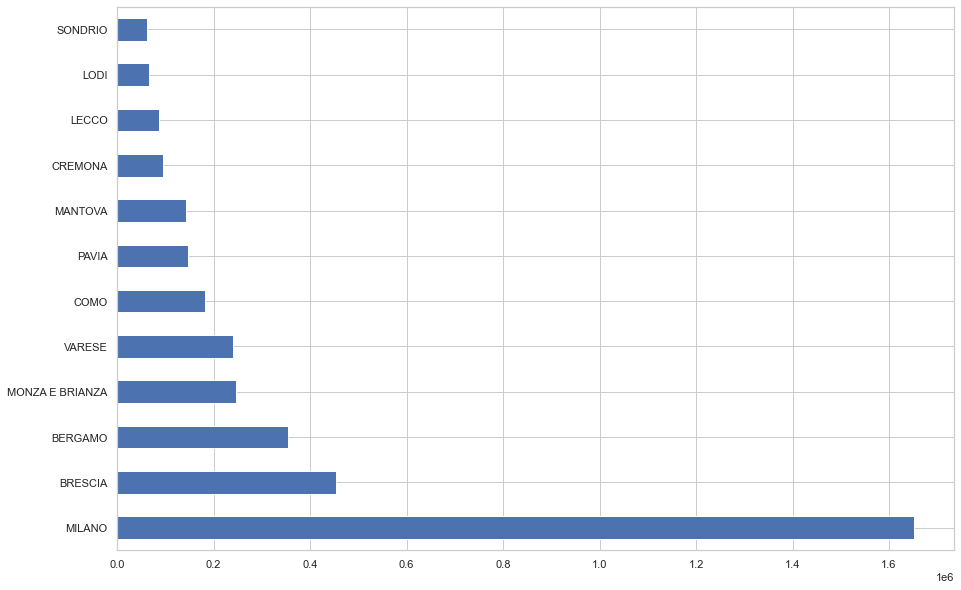

In [83]:
utils.plot_frequency_table(ceased_labours, 'PROVINCIAIMPRESA')

We can guess that in Milan people tend to change job more frequently, or that Milan has a working poputlation that is higher than other cities.
To verify this guess we can integrate this analysy with other data, for example from istat.

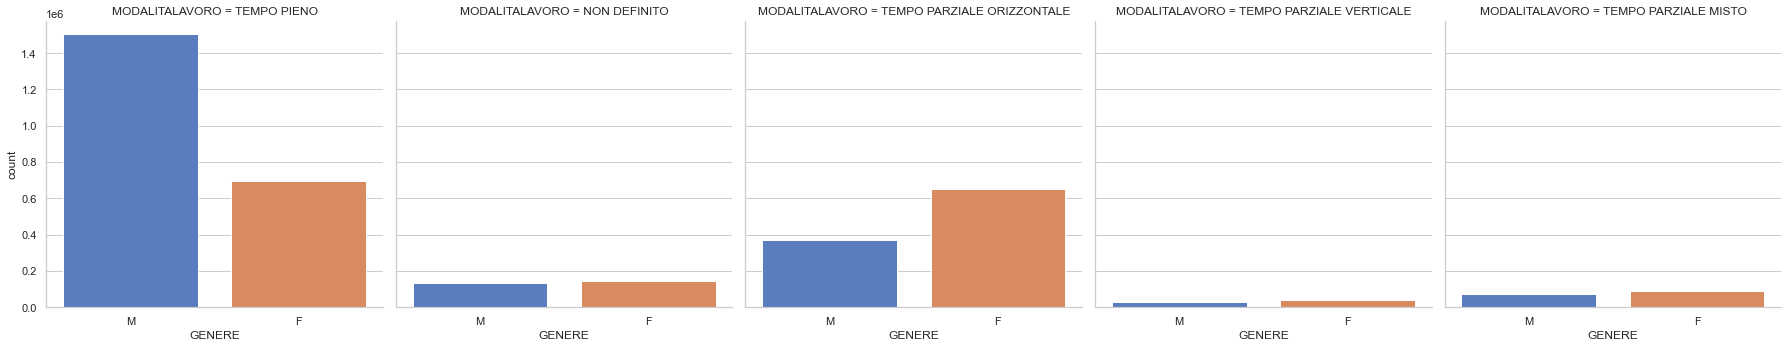

In [84]:
sns.set(style="whitegrid")
g = sns.catplot(x="GENERE", col="MODALITALAVORO", kind="count", data=ceased_labours, palette="muted")

Women that works part time, especially horizontally, seems to have more probability to be fired than men. But when working full time they are less subject to firing.

# Transformations

In [85]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

In [86]:
ceased_transformed = pd.DataFrame()

##### GENERE -> dummies

In [87]:
df_col = ceased_labours['GENERE'].values.reshape(-1,1)
df_col

array([['M'],
       ['F'],
       ['F'],
       ...,
       ['M'],
       ['M'],
       ['M']], dtype=object)

In [88]:
X = one_hot_encoder.fit_transform(df_col).toarray()

In [89]:
ceased_transformed = pd.concat(
    [ceased_transformed, pd.DataFrame(X, columns=['GENERE_F', 'GENERE_M'])],
    axis=1
)
ceased_transformed.head()

,GENERE_F,GENERE_M
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


##### TITOLO STUDIO -> custom transformation
following this ordinal rules [ISTAT document](https://www.istat.it/it/files/2011/01/Classificazione-titoli-studio-28_ott_2005-nota_metodologica.pdf)

In [90]:
ceased_labours.TITOLOSTUDIO.unique()

array(["DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA",
       'LICENZA MEDIA',
       "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()",
       'LICENZA ELEMENTARE', 'NESSUN TITOLO DI STUDIO',
       'LAUREA - Vecchio o nuovo ordinamento', 'DIPLOMA UNIVERSITARIO',
       'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI STUDIO POST-LAUREA',
       'TITOLO DI DOTTORE DI RICERCA',
       'MASTER UNIVERSITARIO DI PRIMO LIVELLO',
       'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO'], dtype=object)

In [91]:
mapper = {
    'NESSUN TITOLO DI STUDIO': 0,
    'LICENZA ELEMENTARE': 1,
    'LICENZA MEDIA': 2,
    'TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L\'ACCESSO ALL\'UNIVERSITÀ ()': 3,
    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L\'ACCESSO ALL\'UNIVERSITA': 4,
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 5,
    'DIPLOMA UNIVERSITARIO': 6,
    'LAUREA - Vecchio o nuovo ordinamento': 7,
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 8,
    'DIPLOMA DI SPECIALIZZAZIONE': 9,
    'TITOLO DI DOTTORE DI RICERCA': 10,
    'TITOLO DI STUDIO POST-LAUREA': 11
}
ceased_transformed['TITOLOSTUDIO'] = ceased_labours['TITOLOSTUDIO'].replace(mapper)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO
0,0.0,1.0,4.0
1,1.0,0.0,4.0
2,1.0,0.0,4.0
3,0.0,1.0,2.0
4,0.0,1.0,2.0


In [92]:
ceased_transformed.TITOLOSTUDIO.unique()

array([ 4.,  2.,  3.,  1.,  0., nan,  7.,  6.,  9., 11., 10.,  8.,  5.])

##### TODO: inspect why missing values are introduced

In [93]:
utils.missing_values_table(ceased_transformed)

Your selected dataframe has 3 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
TITOLOSTUDIO,12992,0.3


##### MODALITÀ LAVORO, PROVINCIAIMPRESA, NAZIONALITA -> LabelEncoder

In [94]:
ceased_transformed['MODALITALAVORO'] = label_encoder.fit_transform(ceased_labours.MODALITALAVORO)
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO
0,0.0,1.0,4.0,4
1,1.0,0.0,4.0,4
2,1.0,0.0,4.0,4
3,0.0,1.0,2.0,4
4,0.0,1.0,2.0,4


In [95]:
ceased_transformed['PROVINCIAIMPRESA'] = label_encoder.fit_transform(ceased_labours.PROVINCIAIMPRESA)

In [96]:
ceased_transformed['NAZIONALITA'] = label_encoder.fit_transform(ceased_labours.PROVINCIAIMPRESA)

In [97]:
ceased_transformed.MODALITALAVORO.unique()

array([4, 0, 2, 3, 1])

In [98]:
ceased_transformed.NAZIONALITA.unique()

array([ 0,  4,  1,  2,  5,  6,  3,  9,  7, 11, 10,  8])

In [99]:
ceased_transformed.PROVINCIAIMPRESA.unique()

array([ 0,  4,  1,  2,  5,  6,  3,  9,  7, 11, 10,  8])

# Time Analysis

In [100]:
timed_labours = ceased_labours.copy()

##### Convert 'DATA' column into datetime field

Control the format

In [101]:
r = re.compile(r'[0-9][0-9]\/[0-9][0-9]\/[0-9][0-9][0-9][0-9]')
regmatch = np.vectorize(lambda x: bool(r.match(x)))

matches = regmatch(timed_labours.DATA.values)
if np.count_nonzero(matches) == len(timed_labours.DATA):
    print("All the values in the data columns matches the pattern")
else:
    raise Exception("ERROR: not all the values in the data columns matches the pattern")

All the values in the data columns matches the pattern


Convert the data

In [102]:
timed_labours.DATA= timed_labours.DATA.apply(
    lambda date_str: datetime.strptime(date_str, "%d/%m/%Y")
)

In [103]:
timed_labours.DATA.head()

0   2019-04-02
1   2018-06-08
2   2016-02-02
3   2015-01-12
4   2017-08-09
Name: DATA, dtype: datetime64[ns]

In [104]:
timed_labours.dtypes

DATA                         datetime64[ns]
GENERE                               object
ETA                                   int64
SETTOREECONOMICODETTAGLIO            object
TITOLOSTUDIO                         object
CONTRATTO                            object
MODALITALAVORO                       object
PROVINCIAIMPRESA                     object
NAZIONALITA                          object
dtype: object

Sort by date

In [105]:
utils.sort_by(timed_labours, 'DATA')

Sorted


Create the month and year columns

In [106]:
timed_labours['MONTH'] = timed_labours.DATA.apply(lambda _date: _date.month)

In [107]:
timed_labours['YEAR'] = timed_labours.DATA.apply(lambda _date: _date.year)

Set the DATA columns as the index

In [108]:
timed_labours.set_index('DATA', inplace=True)

Distribution of ceased labours in all years by month

In [109]:
monthly_count = timed_labours.groupby(timed_labours.index.month).count().iloc[:, [0]]
monthly_count.rename(columns={'GENERE': 'COUNT'}, inplace=True)
monthly_count

,COUNT
DATA,
1,439207
2,477084
3,436162
4,408013
5,326566
6,225558
7,231168
8,218143
9,236740


<AxesSubplot:title={'center':'Ceased labours for every month of each year'}, xlabel='months', ylabel='counts'>

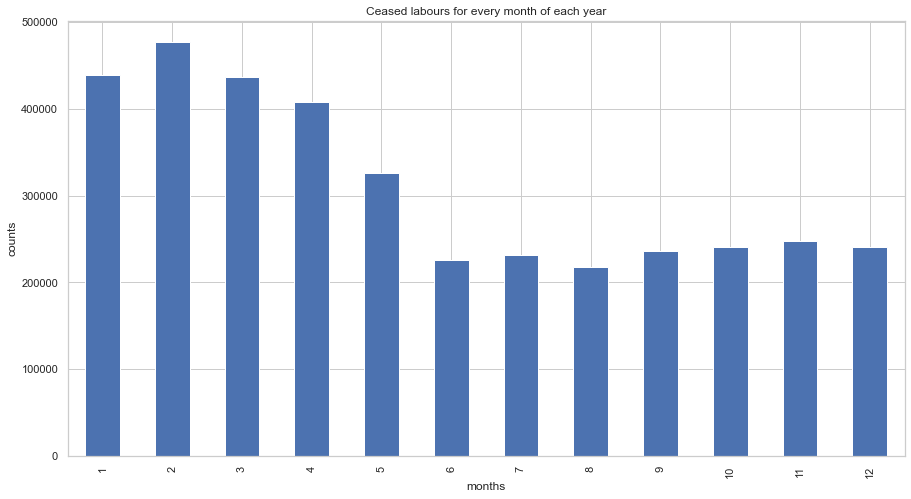

In [110]:
monthly_count.plot(
    title='Ceased labours for every month of each year',
    xlabel='months',
    ylabel='counts',
    kind='bar',
    legend=False,
    figsize=(15, 8)
)

##### Analyze the time series

In [111]:
timed_labours2 = timed_labours[['GENERE']]

In [112]:
timed_labours2 = timed_labours2.resample('M').count()
timed_labours2.rename(columns={'GENERE': 'COUNT'}, inplace=True)

In [113]:
# filter data that are too low
timed_labours2 = timed_labours2[timed_labours2.COUNT > 5000]

<AxesSubplot:xlabel='DATA'>

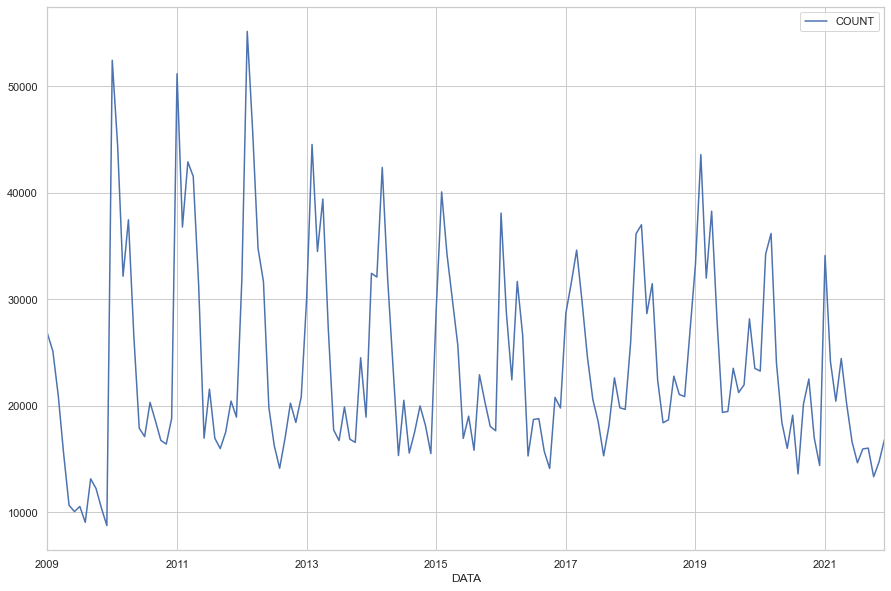

In [114]:
timed_labours2.plot()

Autocorrelation

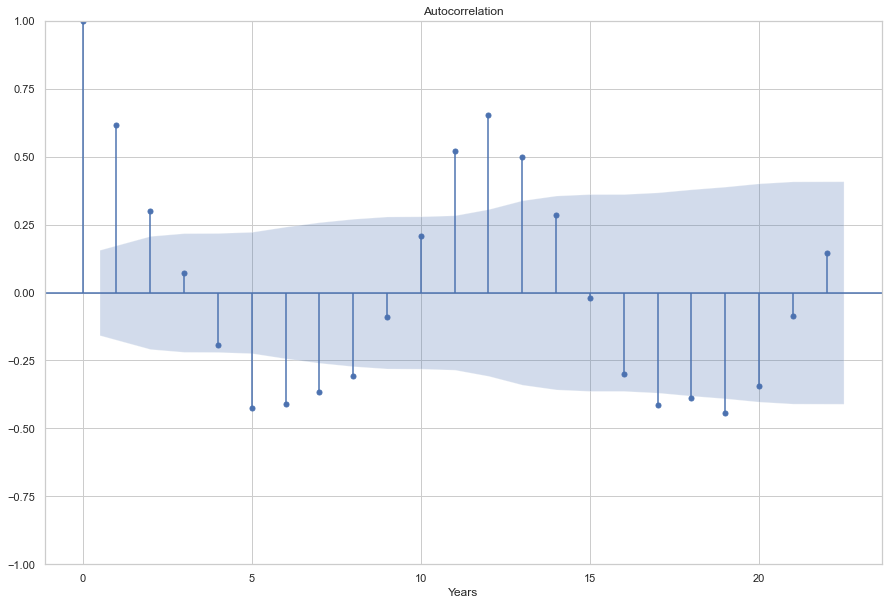

In [115]:
plt.rc('figure', figsize=(15, 10))
plot_acf(timed_labours2)
plt.xlabel('Years')
plt.show()

There is a little correlation during the first day of the months

# Machine learning 

In [116]:
ceased_transformed.head()

,GENERE_F,GENERE_M,TITOLOSTUDIO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
0,0.0,1.0,4.0,4,0,0
1,1.0,0.0,4.0,4,0,0
2,1.0,0.0,4.0,4,0,0
3,0.0,1.0,2.0,4,0,0
4,0.0,1.0,2.0,4,0,0
